In [73]:
from construct_eq_fpr_df import construct_df_for_eq_div_fpr
from get_data_compas import get_recid_compas_df
from get_data_compas import get_compas_fpr_tpr
from get_data_compas import get_totals_and_fraction_recidivists
from construct_eq_fpr_df import get_fpr_eq_div
from onehalfthreshold import get_optimal_fp_tp
from onehalfthreshold import get_indices_for_a_opt
from onehalfthreshold import get_fpa_opt_tpa_opt_thres_a_opt
from onehalfthreshold import get_optimal_fp_tp_hardtf
from matplotlib.font_manager import FontProperties
import pandas as pd 
import matplotlib.pylab as plt 
import pylab
from fairmlbook.code.creditscore_compas import criteria
import numpy as np 

In [74]:
%%markdown
# Data

# Data


In [75]:
recid_w_b_df = get_recid_compas_df()
fpr_df, tpr_df = get_compas_fpr_tpr(recid_w_b_df)
fraction_recidivists,totals = get_totals_and_fraction_recidivists(recid_w_b_df)

list_attrs = ['White','Black']

data_fpr_Black = fpr_df['Black']
data_tpr_Black = tpr_df['Black']

data_fpr_White = fpr_df['White']
data_tpr_White = tpr_df['White']


In [76]:
eq_fpr_df = construct_df_for_eq_div_fpr(fpr_df,tpr_df,division=0.001)
print(eq_fpr_df)

Index(['Black', 'White'], dtype='object')
        Black_tpr Black_threshold   White_tpr White_threshold
0.000           0              11           0              11
0.001  0.00358435         10.9687  0.00356282         10.9206
0.002   0.0071687         10.9374  0.00712564         10.8412
0.003    0.010753          10.906   0.0106885         10.7618
0.004   0.0143374         10.8747   0.0142513         10.6824
...           ...             ...         ...             ...
0.995    0.998632         1.02785    0.997963         1.01356
0.996    0.998906         1.02228     0.99837         1.01085
0.997    0.999179         1.01671    0.998778         1.00813
0.998    0.999453         1.01114    0.999185         1.00542
0.999    0.999726         1.00557    0.999593         1.00271

[1000 rows x 4 columns]


In [77]:
drop_thresholds_df = eq_fpr_df.drop(columns = ['Black_threshold','White_threshold'])
print(drop_thresholds_df)

        Black_tpr   White_tpr
0.000           0           0
0.001  0.00358435  0.00356282
0.002   0.0071687  0.00712564
0.003    0.010753   0.0106885
0.004   0.0143374   0.0142513
...           ...         ...
0.995    0.998632    0.997963
0.996    0.998906     0.99837
0.997    0.999179    0.998778
0.998    0.999453    0.999185
0.999    0.999726    0.999593

[1000 rows x 2 columns]


In [78]:
%%markdown 
## Pointwise minimum of the roc curves 

## Pointwise minimum of the roc curves 


In [79]:
pointwise_min_df = drop_thresholds_df.min(axis=1)
print(pointwise_min_df)

0.000    0.000000
0.001    0.003563
0.002    0.007126
0.003    0.010688
0.004    0.014251
           ...   
0.995    0.997963
0.996    0.998370
0.997    0.998778
0.998    0.999185
0.999    0.999593
Length: 1000, dtype: float64


In [80]:
eq_fpr = list(get_fpr_eq_div(division=0.001))
min_tpr = list(pointwise_min_df)

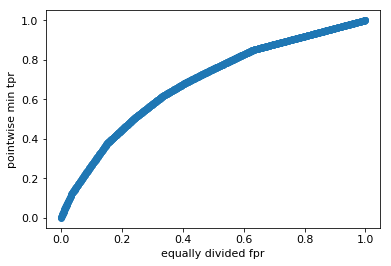

In [81]:
plt.plot(eq_fpr,min_tpr,'-o')
plt.xlabel('equally divided fpr')
plt.ylabel('pointwise min tpr')
plt.show()

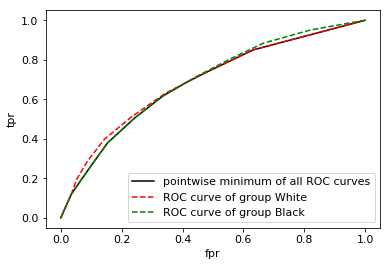

In [82]:
plt.plot(eq_fpr,min_tpr,'k',label='pointwise minimum of all ROC curves')
plt.plot(data_fpr_White, data_tpr_White,'--r',label='ROC curve of group White')
plt.plot(data_fpr_Black,data_tpr_Black,'--g',label='ROC curve of group Black')

plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [83]:
%%markdown 
# Optimal false positive and true positive 

# Optimal false positive and true positive 


In [84]:
#Showing opt for a particular loss function ratio
loss_fn,loss_fp = 0.3,0.2 #cost of a non-defaulter not getting a loan, cost of a defaulter getting a loan
opt_fp, opt_tp = get_optimal_fp_tp(loss_fn,loss_fp,pointwise_min_df,eq_fpr)
print('optimal fp:', opt_fp)
print('optimal tp:', opt_tp)

optimal fp: 0.631
optimal tp: 0.849600558081852


In [85]:
%%markdown 
## Obtaining optimal false positive and true positive rates for cost matrix

## Obtaining optimal false positive and true positive rates for cost matrix


In [86]:
%%markdown 
## Optimal false positive and true positive rates output from semi-threshold classifier framework 

## Optimal false positive and true positive rates output from semi-threshold classifier framework 


In [102]:
target_rate = 1/2 #(this means loss from loaning to defaulter is 6 times as expensive as for profit from loaning to non-defaulter)
profit_semi, opt_fp_semi,opt_tp_semi = get_optimal_fp_tp_hardtf(totals, fraction_recidivists,target_rate,pointwise_min_df, eq_fpr) 
print('optimal fp from semi-threshold classifiers with target rate:' + str(target_rate) + '=', opt_fp_semi)
print('optimal tp from semi-threshold classifiers with target rate:' + str(target_rate) + '=', opt_tp_semi)
print('optimal profit from semi-threshold classifiers with target rate:' + str(target_rate) + '=', profit_semi)


optimal fp from semi-threshold classifiers with target rate:0.5= 0.334
optimal tp from semi-threshold classifiers with target rate:0.5= 0.6155071931047595
optimal profit from semi-threshold classifiers with target rate:0.5= 426.1707590468344


In [88]:
%%markdown 
## Optimal false positive and true positive rates outfput from Hardt, Price and Sebro's framework 

## Optimal false positive and true positive rates outfput from Hardt, Price and Sebro's framework 


In [103]:
entire_df = pd.read_csv("compas-scores-two-years.csv")
recid_df = entire_df[['race','decile_score','is_recid']]
recid_df_w_b = recid_df[(recid_df['race'] == 'African-American') | (recid_df['race'] == 'Caucasian')]

data = criteria.CriteriaData.from_individuals(recid_df_w_b,binsize=0.025) 
result = data.two_sided_optimum(target_rate)
profit_hps, opt_fp_hps, opt_tp_hps = result[0],result[1][1],result[1][0]
print('optimal fp from Hardt,Price and Sebro\'s framework with target rate:' + str(target_rate) + '=' , opt_fp_hps)
print('optimal tp from Hardt,Price and Sebro\'s framework with target rate:' + str(target_rate) + '=', opt_tp_hps)
print('optimal profit from Hardt,Price and Sebro\'s framework with target rate:' + str(target_rate) + '=', profit_hps)

/Users/nikitarajaneesh/PycharmProjects/Fairness_scorefunction_predictors/fairmlbook/code/creditscore_compas/criteria.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfs[group][num_per_score.index] = num_per_score.values


optimal fp from Hardt,Price and Sebro's framework with target rate:0.5= 0.3343373493975903
optimal tp from Hardt,Price and Sebro's framework with target rate:0.5= 0.6159135559921415
optimal profit from Hardt,Price and Sebro's framework with target rate:0.5= 426.2716613013943


In [90]:
%%markdown
## Plot data 

## Plot data 


In [91]:
%%markdown 
### Single target rate 

### Single target rate 


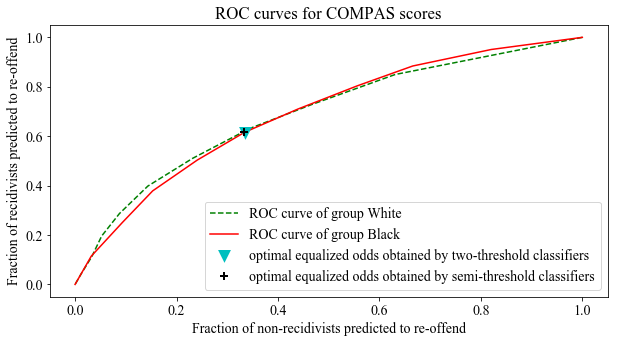

In [105]:
f = plt.figure(figsize=(10, 5))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
#plt.plot(eq_fpr,min_tpr,'k',label='pointwise minimum of all ROC curves')
plt.plot(data_fpr_White, data_tpr_White,'--g',label='ROC curve of group White')
plt.plot(data_fpr_Black,data_tpr_Black,'-r',label='ROC curve of group Black')
plt.plot(opt_fp_hps, opt_tp_hps,'vc',mew=3, ms=8,label = 'optimal equalized odds obtained by two-threshold classifiers')
plt.plot(opt_fp_semi,opt_tp_semi,'+k',mew=2, ms=8,label = 'optimal equalized odds obtained by semi-threshold classifiers')
#plt.xlim([0,1])
#plt.ylim([0.3,1])

plt.legend(loc=0)

plt.xlabel('Fraction of non-recidivists predicted to re-offend')
plt.ylabel('Fraction of recidivists predicted to re-offend')
plt.title('ROC curves for COMPAS scores')
plt.show()
#f.savefig('figures/zoomed_compas_tr_1_3.png')
#f.savefig('figures/compas_tr_1_3.png')


In [93]:
%%markdown 
### Many target rates 

### Many target rates 


0.000&0.999&0.631&1.000& 0.850& -3059.753&-2601.103& 458.650 \\ \hline
0.020&0.999&0.631&1.000& 0.850& -2936.840&-2510.085& 426.755 \\ \hline
0.040&0.999&0.631&1.000& 0.850& -2813.926&-2419.067& 394.860 \\ \hline
0.060&0.999&0.631&1.000& 0.850& -2691.013&-2328.049& 362.964 \\ \hline
0.080&0.999&0.631&1.000& 0.850& -2568.100&-2237.030& 331.069 \\ \hline
0.100&0.999&0.631&1.000& 0.850& -2445.187&-2146.012& 299.174 \\ \hline
0.120&0.999&0.631&1.000& 0.850& -2322.273&-2054.994& 267.279 \\ \hline
0.140&0.999&0.631&1.000& 0.850& -2199.360&-1963.976& 235.384 \\ \hline
0.160&0.999&0.631&1.000& 0.850& -2076.447&-1872.957& 203.489 \\ \hline
0.180&0.999&0.631&1.000& 0.850& -1953.533&-1781.939& 171.594 \\ \hline
0.200&0.999&0.631&1.000& 0.850& -1830.620&-1690.921& 139.699 \\ \hline
0.220&0.999&0.631&1.000& 0.850& -1707.707&-1599.903& 107.804 \\ \hline
0.240&0.999&0.631&1.000& 0.850& -1584.794&-1508.884& 75.909 \\ \hline
0.260&0.999&0.631&1.000& 0.850& -1461.880&-1417.866& 44.014 \\ \hline
0.280&0.

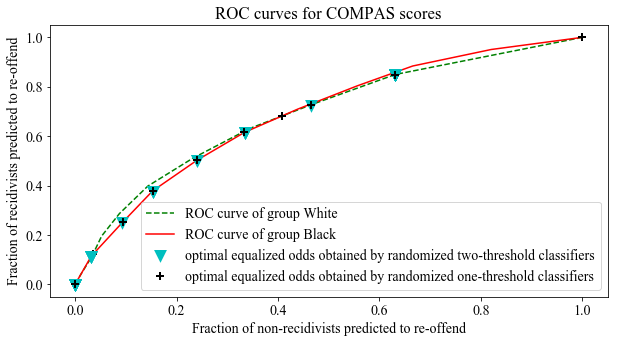

In [107]:
f = plt.figure(figsize=(10, 5))
#plt.plot(eq_fpr,min_tpr,'k',label='pointwise minimum of all ROC curves')
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
plt.plot(data_fpr_White, data_tpr_White,'--g',label='ROC curve of group White')
plt.plot(data_fpr_Black,data_tpr_Black,'-r',label='ROC curve of group Black')

for target_rate in np.arange(0,1,0.02):
    profit_semi, opt_fp_semi,opt_tp_semi = get_optimal_fp_tp_hardtf(totals, fraction_recidivists,target_rate,pointwise_min_df, eq_fpr) 
    result = data.two_sided_optimum(target_rate) #same target rate we used for semi-threshold classifiers 
    profit_hps, opt_fp_hps, opt_tp_hps = result[0],result[1][1],result[1][0]
    
    plt.plot(opt_fp_hps, opt_tp_hps,'vc',mew=3, ms=8)
    plt.plot(opt_fp_semi,opt_tp_semi,'+k',mew=2, ms=8)
    
    #print('optimal fp from linear program assuming concave roc curves with target rate:' + str(target_rate) + '=', opt_fp_semi)
   # print('optimal tp from linear program assuming concave roc curves with target rate:' + str(target_rate) + '=', opt_tp_semi)
   # print('optimal profit from semi-threshold classifiers with target rate:' + str(target_rate) + '=', profit_semi)
    
   # print('optimal fp from Hardt,Price and Sebro\'s framework with target rate:' + str(target_rate) + '=' , opt_fp_hps)
   # print('optimal tp from Hardt,Price and Sebro\'s framework with target rate:' + str(target_rate) + '=', opt_tp_hps)
   # print('optimal profit from Hardt,Price and Sebro\'s framework with target rate:' + str(target_rate) + '=', profit_hps)

    print("{:.3f}".format(target_rate) + '&' + "{:.3f}".format(opt_fp_semi) + '&' + "{:.3f}".format(opt_fp_hps) + '&' + 
         "{:.3f}".format(opt_tp_semi) + '& ' +  "{:.3f}".format(opt_tp_hps) + '& ' + "{:.3f}".format(-profit_semi) + '&' + 
         "{:.3f}".format(-profit_hps) + '& ' + "{:.3f}".format(-(profit_hps - profit_semi)) + " \\\ \hline")
#get a trivial point value for target rate > 0.8
    
plt.plot(opt_fp_hps, opt_tp_hps,'vc',mew=3, ms=8,label = 'optimal equalized odds obtained by randomized two-threshold classifiers')
plt.plot(opt_fp_semi,opt_tp_semi,'+k',mew=2, ms=8,label = 'optimal equalized odds obtained by randomized one-threshold classifiers')

plt.legend(loc=0)

plt.xlabel('Fraction of non-recidivists predicted to re-offend')
plt.ylabel('Fraction of recidivists predicted to re-offend')
plt.title('ROC curves for COMPAS scores')
plt.show()
f.savefig('figures/diff_cost_ratios_compas',dpi=300)

In [ ]:
%%markdown 
## Find threshold and probability of semi-threshold classifier for each attribute (at diff target rates)

In [ ]:
#Opt values for different loss function ratios! 
target_rate_list = [2/3,1/3,4/7,1/2]
opt_fp_list = []
opt_tp_list = []

for i in range(0, len(target_rate_list)):
    profit,opt_semi_fp, opt_semi_tp = get_optimal_fp_tp_hardtf(totals, fraction_recidivists,target_rate_list[i],pointwise_min_df, eq_fpr) 
    print('optimal fp:', opt_semi_fp)
    print('optimal tp:', opt_semi_tp)
    opt_fp_list.append(opt_semi_fp)
    opt_tp_list.append(opt_semi_tp)
    

In [ ]:
ta_pa_attr_dict = {'White': ([],[]), 'Black': ([],[])}
f = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 10})
for i in range(0,len(opt_fp_list)):
    opt_slope = opt_tp_list[i]/opt_fp_list[i]
    print('Opt ratio: ',opt_slope)
    same_opt_ratio_ta = []
    same_opt_ratio_pa = []
    for attr in list_attrs: 
        tp_attr_list = list(eq_fpr_df[attr+'_tpr'])
        found_index_1, found_index_2 = get_indices_for_a_opt(opt_slope,eq_fpr,tp_attr_list,0,len(eq_fpr) - 1)
        threshold_attr_list = list(eq_fpr_df[attr+'_threshold'])
        fpr_1 = eq_fpr[found_index_1]
        fpr_2 = eq_fpr[found_index_2]
        tpr_1 = tp_attr_list[found_index_1]
        tpr_2 = tp_attr_list[found_index_2]
        threshold_1 = threshold_attr_list[found_index_1]
        threshold_2 = threshold_attr_list[found_index_2]
        fpa_opt,tpa_opt,threshold_a_opt = get_fpa_opt_tpa_opt_thres_a_opt(fpr_1,fpr_2,tpr_1,tpr_2,threshold_1,threshold_2,opt_slope)
        p_a = opt_fp_list[i]/fpa_opt #=opt_tp/tpa_opt
        same_opt_ratio_ta.append(threshold_a_opt)
        same_opt_ratio_pa.append(p_a)
        ta_pa_attr_dict[attr][0].append(p_a)
        ta_pa_attr_dict[attr][1].append(threshold_a_opt)
        print('Opt false positive one threshold for group '+attr+':',fpa_opt)
        print('Opt true positive one threshold for group '+attr+':',tpa_opt)
        print('Opt threshold one threshold for group '+attr+':',threshold_a_opt)
        print('Opt probablity p_a group '+attr+':',p_a)
    
    plt.plot(same_opt_ratio_pa,same_opt_ratio_ta,'o',label='target_rate='+"{:.2f}".format(target_rate_list[i]))
    
for attr,val in ta_pa_attr_dict.items():
    plt.plot(ta_pa_attr_dict[attr][0],ta_pa_attr_dict[attr][1],'-',label='group = '+attr)

plt.legend(loc=0)

plt.title('Threshold and Probability for semi-threshold classifier')
plt.xlabel('Probability for each group')
plt.ylabel('Threshold for each group')    
plt.show()

#f.savefig('figures/threshold_prob_compas')